In [2]:
# 필요 라이브러리 import

import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import os

In [ ]:
# # 데이터셋을 불러오기위한 라이브러리 import

# import tensorflow_datasets as tfds

# # cat vs dog 데이터셋 불러오기

# (raw_train, raw_validation, raw_test), metadata = tfds.load(
#     'cats_vs_dogs',
#     split=['train[:80%]','train[80%:90%]','train[90%:]'],
#     with_info=True,
#     as_supervised=True
# )

In [ ]:
# tfds 오류 떠서 링크에서 직접 가져옴
!wget https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

In [ ]:
!unzip kagglecatsanddogs_5340.zip

In [ ]:
!rm kagglecatsanddogs_5340.zip

In [ ]:
# 각 클래스별 파일 갯수 확인

dog_list = os.listdir('./PetImages/Dog/')
cat_list = os.listdir('./PetImages/Cat/')

print(f'dog : {len(dog_list)}')
print(f'cat : {len(cat_list)}')

In [ ]:
for i in (dog_list + cat_list):
    if i[-3:] != 'jpg':
        print(i)    

In [11]:
# https://discuss.tensorflow.org/t/first-steps-in-keras-error/8049/11
#Filter out corrupted images

from PIL import Image

num_skipped = 0

for folder_name in ("Cat", "Dog"):
    folder_path = os.path.join("PetImages", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        if fname.endswith('.jpg'):
            try:
                img = Image.open(fpath) # open the image file
                #print("%s", fpath)
                exif_data = img._getexif()
                img.verify() # verify that it is, in fact an image
            except:
                num_skipped += 1
                # Delete corrupted image
                os.remove(fpath)
print("PIL deleted %d images" % num_skipped)

/opt/conda/lib/python3.9/site-packages/PIL/TiffImagePlugin.py:811: UserWarning: Truncated File Read
  warnings.warn(str(msg))


PIL deleted 0 images


In [13]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  './PetImages/',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(224, 224),
  batch_size=10)

Found 24769 files belonging to 2 classes.
Using 19816 files for training.


In [14]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  './PetImages/',
  validation_split=0.2,
  subset="validation",
  seed=123,
  shuffle=True,
  image_size=(224, 224),
  batch_size=10)

Found 24769 files belonging to 2 classes.
Using 4953 files for validation.


In [22]:
class_names = train_ds.class_names

print(class_names)

['Cat', 'Dog']


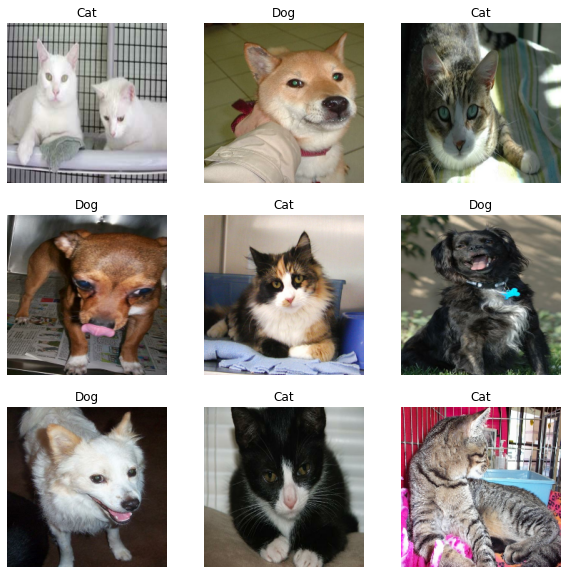

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [5]:

import tensorflow as tf
import numpy as np
from tensorflow import keras

In [6]:
def build_resnet_block(
    input_layer, block_num, cnn, channel, strides, not_plain=True, is_50=False
):
    x = input_layer

    identity_mapping = x
    for num_cnn in range(cnn):
        # layer 1
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(1, 1) if is_50 else (3, 3),
            strides=strides,
            kernel_initializer="he_normal",
            padding="same",
            name=f"blcok{block_num}_conv{num_cnn}_1",
        )(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation("relu")(x)

        # layer 2
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3, 3),
            strides=1,
            kernel_initializer="he_normal",
            padding="same",
            name=f"blcok{block_num}_conv{num_cnn}_2",
        )(x)
        x = keras.layers.BatchNormalization()(x)

        # layer 3
        if is_50:
            x = keras.layers.Activation("relu")(x)
            x = keras.layers.Conv2D(
                filters=(channel * 4),
                kernel_size=(1, 1),
                strides=1,
                kernel_initializer="he_normal",
                padding="same",
                name=f"blcok{block_num}_conv{num_cnn}_3",
            )(x)
            x = keras.layers.BatchNormalization()(x)

        if not_plain:
            identity_mapping = keras.layers.Conv2D(
                filters=(channel * 4) if is_50 else channel,
                kernel_size=(1, 1),
                strides=strides,
                padding="same",
                name=f"blcok{block_num}_identity_conv{num_cnn}",
            )(identity_mapping)
            identity_mapping = keras.layers.BatchNormalization()(identity_mapping)
            x = keras.layers.Add()([x, identity_mapping])

        if strides != 1:
            strides = 1

        x = keras.layers.Activation("relu")(x)

    return x

In [7]:
def build_resnet(input_shape, is_50=False, not_plain = True):
    input_layer = keras.layers.Input(shape = input_shape)
    
    setting = {'resnet34_cnn_list': [3, 4, 6, 3], 'channel_list': [64, 128, 256, 512]}
    
    resnet_output = keras.layers.Rescaling(1.0 / 255)(input_layer)
    resnet_output = keras.layers.ZeroPadding2D()(resnet_output)
    resnet_output = keras.layers.Conv2D(64, (7, 7),
                      strides=2,
                      padding='same',
                      kernel_initializer='he_normal')(resnet_output)
    resnet_output = keras.layers.BatchNormalization()(resnet_output)
    resnet_output = keras.layers.Activation('relu')(resnet_output)
    resnet_output = keras.layers.MaxPooling2D((3, 3), strides=2)(resnet_output)
    
    for i, (cnn, channel) in enumerate(zip(setting['resnet34_cnn_list'], setting['channel_list'])):
        strides = 1 if i == 0 else 2
        
        resnet_output = build_resnet_block(resnet_output,
                                           block_num = i,
                                           cnn = cnn,
                                           channel = channel,
                                           strides = strides,
                                           not_plain = not_plain,
                                           is_50 = is_50)
    
    resnet_output = keras.layers.AveragePooling2D()(resnet_output)
    resnet_output = keras.layers.Flatten()(resnet_output)
    resnet_output = keras.layers.Dense(1, activation='sigmoid')(resnet_output)
    
    model = keras.Model(inputs = input_layer,
                        outputs = resnet_output)
    
    return model

In [43]:
resnet34 = build_resnet(input_shape = (224, 224, 3))
resnet34.summary()


Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_9 (Rescaling)         (None, 224, 224, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
zero_padding2d_8 (ZeroPadding2D (None, 226, 226, 3)  0           rescaling_9[0][0]                
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 113, 113, 64) 9472        zero_padding2d_8[0][0]           
____________________________________________________________________________________________

In [44]:
resnet34.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

In [45]:
resnet34 = resnet34.fit(
        train_ds,
        epochs=3,
        validation_data=val_ds
    )

Epoch 1/3
 64/620 [==>...........................] - ETA: 1:53 - loss: 0.9917 - accuracy: 0.5703

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


216/620 [=========>....................] - ETA: 1:23 - loss: 0.7768 - accuracy: 0.6155

311/620 [==============>...............] - ETA: 1:03 - loss: 0.7318 - accuracy: 0.6346

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/620 [===============>..............] - ETA: 57s - loss: 0.7240 - accuracy: 0.6361

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


351/620 [===============>..............] - ETA: 55s - loss: 0.7219 - accuracy: 0.6361

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


473/620 [=====================>........] - ETA: 30s - loss: 0.6869 - accuracy: 0.6511

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


507/620 [=======================>......] - ETA: 23s - loss: 0.6798 - accuracy: 0.6539

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


530/620 [========================>.....] - ETA: 18s - loss: 0.6745 - accuracy: 0.6564

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


571/620 [==========================>...] - ETA: 10s - loss: 0.6661 - accuracy: 0.6606

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


620/620 [==============================] - ETA: 0s - loss: 0.6578 - accuracy: 0.6656

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


620/620 [==============================] - 143s 223ms/step - loss: 0.6578 - accuracy: 0.6656 - val_loss: 0.7915 - val_accuracy: 0.6955
Epoch 2/3
 64/620 [==>...........................] - ETA: 1:54 - loss: 0.5551 - accuracy: 0.7300

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


216/620 [=========>....................] - ETA: 1:23 - loss: 0.5242 - accuracy: 0.7491

311/620 [==============>...............] - ETA: 1:03 - loss: 0.5211 - accuracy: 0.7509

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/620 [===============>..............] - ETA: 57s - loss: 0.5195 - accuracy: 0.7508

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


351/620 [===============>..............] - ETA: 55s - loss: 0.5193 - accuracy: 0.7513

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


473/620 [=====================>........] - ETA: 30s - loss: 0.5054 - accuracy: 0.7587

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


507/620 [=======================>......] - ETA: 23s - loss: 0.5024 - accuracy: 0.7601

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


530/620 [========================>.....] - ETA: 18s - loss: 0.5000 - accuracy: 0.7620

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


571/620 [==========================>...] - ETA: 10s - loss: 0.4949 - accuracy: 0.7644

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


620/620 [==============================] - ETA: 0s - loss: 0.4923 - accuracy: 0.7656

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


620/620 [==============================] - 138s 222ms/step - loss: 0.4923 - accuracy: 0.7656 - val_loss: 0.7426 - val_accuracy: 0.6449
Epoch 3/3
 64/620 [==>...........................] - ETA: 1:54 - loss: 0.4473 - accuracy: 0.7910

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


216/620 [=========>....................] - ETA: 1:22 - loss: 0.4238 - accuracy: 0.8037

311/620 [==============>...............] - ETA: 1:03 - loss: 0.4141 - accuracy: 0.8082

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/620 [===============>..............] - ETA: 57s - loss: 0.4120 - accuracy: 0.8095

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


351/620 [===============>..............] - ETA: 55s - loss: 0.4115 - accuracy: 0.8104

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


473/620 [=====================>........] - ETA: 30s - loss: 0.3985 - accuracy: 0.8181

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


507/620 [=======================>......] - ETA: 23s - loss: 0.3994 - accuracy: 0.8179

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


530/620 [========================>.....] - ETA: 18s - loss: 0.3974 - accuracy: 0.8195

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


571/620 [==========================>...] - ETA: 10s - loss: 0.3949 - accuracy: 0.8201

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


620/620 [==============================] - ETA: 0s - loss: 0.3902 - accuracy: 0.8223

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


620/620 [==============================] - 138s 222ms/step - loss: 0.3902 - accuracy: 0.8223 - val_loss: 0.5091 - val_accuracy: 0.7840


In [46]:
resnet34_plain = build_resnet(input_shape = (224, 224, 3), not_plain=False)

In [47]:
resnet34_plain.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

In [48]:
resnet34_plain = resnet34_plain.fit(
        train_ds,
        epochs=3,
        validation_data=val_ds
    )

Epoch 1/3
 64/620 [==>...........................] - ETA: 1:36 - loss: 0.8346 - accuracy: 0.5098

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


216/620 [=========>....................] - ETA: 1:10 - loss: 0.7613 - accuracy: 0.5026

311/620 [==============>...............] - ETA: 53s - loss: 0.7434 - accuracy: 0.5063

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/620 [===============>..............] - ETA: 48s - loss: 0.7421 - accuracy: 0.5078

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


351/620 [===============>..............] - ETA: 46s - loss: 0.7425 - accuracy: 0.5068

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


473/620 [=====================>........] - ETA: 25s - loss: 0.7332 - accuracy: 0.5055

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


507/620 [=======================>......] - ETA: 19s - loss: 0.7305 - accuracy: 0.5051

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


530/620 [========================>.....] - ETA: 15s - loss: 0.7295 - accuracy: 0.5057

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


571/620 [==========================>...] - ETA: 8s - loss: 0.7274 - accuracy: 0.5068

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


620/620 [==============================] - ETA: 0s - loss: 0.7242 - accuracy: 0.5093

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


620/620 [==============================] - 119s 188ms/step - loss: 0.7242 - accuracy: 0.5093 - val_loss: 0.6989 - val_accuracy: 0.5245
Epoch 2/3
 64/620 [==>...........................] - ETA: 1:36 - loss: 0.6920 - accuracy: 0.5469

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


216/620 [=========>....................] - ETA: 1:09 - loss: 0.6906 - accuracy: 0.5447

311/620 [==============>...............] - ETA: 53s - loss: 0.6906 - accuracy: 0.5465

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/620 [===============>..............] - ETA: 48s - loss: 0.6908 - accuracy: 0.5446

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


351/620 [===============>..............] - ETA: 46s - loss: 0.6908 - accuracy: 0.5456

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


473/620 [=====================>........] - ETA: 25s - loss: 0.6909 - accuracy: 0.5462

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


507/620 [=======================>......] - ETA: 19s - loss: 0.6909 - accuracy: 0.5451

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


530/620 [========================>.....] - ETA: 15s - loss: 0.6909 - accuracy: 0.5436

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


571/620 [==========================>...] - ETA: 8s - loss: 0.6907 - accuracy: 0.5419

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


620/620 [==============================] - ETA: 0s - loss: 0.6896 - accuracy: 0.5447

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


620/620 [==============================] - 116s 187ms/step - loss: 0.6896 - accuracy: 0.5447 - val_loss: 0.7085 - val_accuracy: 0.5683
Epoch 3/3
 64/620 [==>...........................] - ETA: 1:36 - loss: 0.6804 - accuracy: 0.5830

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


216/620 [=========>....................] - ETA: 1:09 - loss: 0.6805 - accuracy: 0.5846

311/620 [==============>...............] - ETA: 53s - loss: 0.6785 - accuracy: 0.5872

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


341/620 [===============>..............] - ETA: 48s - loss: 0.6789 - accuracy: 0.5855

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


351/620 [===============>..............] - ETA: 46s - loss: 0.6790 - accuracy: 0.5850

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


473/620 [=====================>........] - ETA: 25s - loss: 0.6790 - accuracy: 0.5838

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


507/620 [=======================>......] - ETA: 19s - loss: 0.6796 - accuracy: 0.5825

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


530/620 [========================>.....] - ETA: 15s - loss: 0.6787 - accuracy: 0.5843

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


571/620 [==========================>...] - ETA: 8s - loss: 0.6776 - accuracy: 0.5868

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


620/620 [==============================] - ETA: 0s - loss: 0.6765 - accuracy: 0.5875

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


620/620 [==============================] - 116s 187ms/step - loss: 0.6765 - accuracy: 0.5875 - val_loss: 0.9601 - val_accuracy: 0.5221


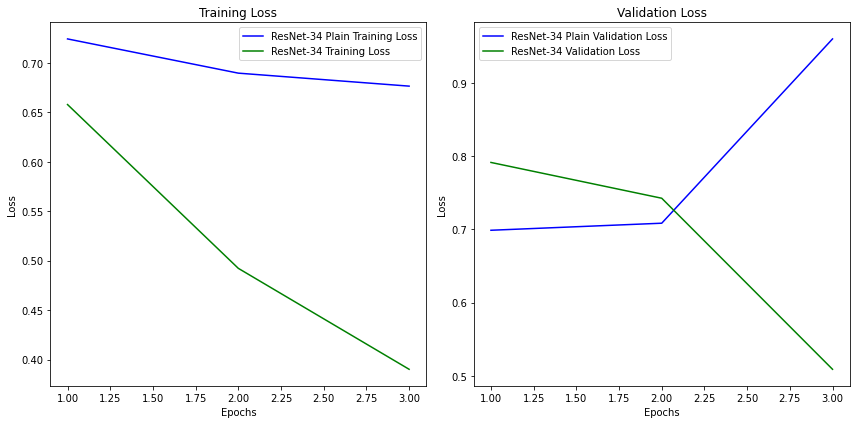

In [49]:
import matplotlib.pyplot as plt

# resnet_34_plain_history와 resnet34_history에서 loss와 val_loss 추출
resnet_34_plain_loss = resnet34_plain.history['loss']
resnet_34_plain_val_loss = resnet34_plain.history['val_loss']

resnet34_loss = resnet34.history['loss']
resnet34_val_loss = resnet34.history['val_loss']

# 훈련 과정에서 얻은 손실 값들을 시각화
epochs = range(1, len(resnet_34_plain_loss) + 1)  # epochs 수

plt.figure(figsize=(12, 6))

# resnet_34_plain , resnet34 모델의 손실 값
plt.subplot(1, 2, 1)
plt.plot(epochs, resnet_34_plain_loss, 'b', label='ResNet-34 Plain Training Loss')
plt.plot(epochs, resnet34_loss, 'g', label='ResNet-34 Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, resnet_34_plain_val_loss, 'b', label='ResNet-34 Plain Validation Loss')
plt.plot(epochs, resnet34_val_loss, 'g', label='ResNet-34 Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
resnet50 = build_resnet(input_shape = (224, 224, 3), is_50=True, not_plain = True)

resnet50_plain = build_resnet(input_shape = (224, 224, 3), is_50=True, not_plain = False)

In [27]:
resnet50.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )


resnet50_plain.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

In [39]:
resnet50 = resnet50.fit(
        train_ds,
        epochs=3,
        validation_data=val_ds
    )

Epoch 1/3
 222/1982 [==>...........................] - ETA: 5:16 - loss: 1.5762 - accuracy: 0.5171

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 708/1982 [=========>....................] - ETA: 3:50 - loss: 0.9634 - accuracy: 0.5564

1014/1982 [==============>...............] - ETA: 2:55 - loss: 0.8670 - accuracy: 0.5767

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1110/1982 [===============>..............] - ETA: 2:37 - loss: 0.8460 - accuracy: 0.5831

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1141/1982 [================>.............] - ETA: 2:32 - loss: 0.8392 - accuracy: 0.5849

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1532/1982 [======================>.......] - ETA: 1:21 - loss: 0.7843 - accuracy: 0.6005

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1642/1982 [=======================>......] - ETA: 1:01 - loss: 0.7734 - accuracy: 0.6041

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1713/1982 [========================>.....] - ETA: 48s - loss: 0.7649 - accuracy: 0.6078

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


1845/1982 [==========================>...] - ETA: 24s - loss: 0.7533 - accuracy: 0.6121

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1982/1982 [==============================] - ETA: 0s - loss: 0.7429 - accuracy: 0.6161

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


1982/1982 [==============================] - 392s 195ms/step - loss: 0.7429 - accuracy: 0.6161 - val_loss: 0.6129 - val_accuracy: 0.6562
Epoch 2/3
 222/1982 [==>...........................] - ETA: 5:19 - loss: 0.5920 - accuracy: 0.6919

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 708/1982 [=========>....................] - ETA: 3:51 - loss: 0.5810 - accuracy: 0.6962

1014/1982 [==============>...............] - ETA: 2:55 - loss: 0.5841 - accuracy: 0.6983

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1110/1982 [===============>..............] - ETA: 2:38 - loss: 0.5887 - accuracy: 0.6929

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1141/1982 [================>.............] - ETA: 2:32 - loss: 0.5889 - accuracy: 0.6917

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1532/1982 [======================>.......] - ETA: 1:21 - loss: 0.5898 - accuracy: 0.6885

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1642/1982 [=======================>......] - ETA: 1:01 - loss: 0.5890 - accuracy: 0.6897

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1713/1982 [========================>.....] - ETA: 48s - loss: 0.5866 - accuracy: 0.6923

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


1845/1982 [==========================>...] - ETA: 24s - loss: 0.5846 - accuracy: 0.6940

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1982/1982 [==============================] - ETA: 0s - loss: 0.5825 - accuracy: 0.6964

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


1982/1982 [==============================] - 386s 195ms/step - loss: 0.5825 - accuracy: 0.6964 - val_loss: 0.6105 - val_accuracy: 0.6820
Epoch 3/3
 222/1982 [==>...........................] - ETA: 5:19 - loss: 0.5420 - accuracy: 0.7311

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 708/1982 [=========>....................] - ETA: 3:51 - loss: 0.5458 - accuracy: 0.7256

1014/1982 [==============>...............] - ETA: 2:55 - loss: 0.5410 - accuracy: 0.7292

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1110/1982 [===============>..............] - ETA: 2:38 - loss: 0.5417 - accuracy: 0.7293

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1141/1982 [================>.............] - ETA: 2:32 - loss: 0.5411 - accuracy: 0.7294

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1532/1982 [======================>.......] - ETA: 1:21 - loss: 0.5379 - accuracy: 0.7298

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1642/1982 [=======================>......] - ETA: 1:01 - loss: 0.5390 - accuracy: 0.7285

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1713/1982 [========================>.....] - ETA: 48s - loss: 0.5373 - accuracy: 0.7304

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


1845/1982 [==========================>...] - ETA: 24s - loss: 0.5359 - accuracy: 0.7316

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1982/1982 [==============================] - ETA: 0s - loss: 0.5333 - accuracy: 0.7342

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


1982/1982 [==============================] - 386s 195ms/step - loss: 0.5333 - accuracy: 0.7342 - val_loss: 0.5498 - val_accuracy: 0.7220


In [28]:
resnet50_plain = resnet50_plain.fit(
        train_ds,
        epochs=3,
        validation_data=val_ds
    )

Epoch 1/3
 223/1982 [==>...........................] - ETA: 2:55 - loss: 0.8960 - accuracy: 0.5027

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 709/1982 [=========>....................] - ETA: 2:08 - loss: 0.7611 - accuracy: 0.4996

1015/1982 [==============>...............] - ETA: 1:37 - loss: 0.7415 - accuracy: 0.5013

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1111/1982 [===============>..............] - ETA: 1:27 - loss: 0.7374 - accuracy: 0.5026

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1142/1982 [================>.............] - ETA: 1:24 - loss: 0.7362 - accuracy: 0.5025

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1533/1982 [======================>.......] - ETA: 45s - loss: 0.7272 - accuracy: 0.5012

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1643/1982 [=======================>......] - ETA: 34s - loss: 0.7251 - accuracy: 0.4999

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1714/1982 [========================>.....] - ETA: 27s - loss: 0.7236 - accuracy: 0.5015

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


1846/1982 [==========================>...] - ETA: 13s - loss: 0.7215 - accuracy: 0.5019

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1982/1982 [==============================] - ETA: 0s - loss: 0.7195 - accuracy: 0.5028

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


1982/1982 [==============================] - 220s 109ms/step - loss: 0.7195 - accuracy: 0.5028 - val_loss: 0.6929 - val_accuracy: 0.4987
Epoch 2/3
 223/1982 [==>...........................] - ETA: 2:57 - loss: 0.6941 - accuracy: 0.5063

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 709/1982 [=========>....................] - ETA: 2:08 - loss: 0.6937 - accuracy: 0.4961

1015/1982 [==============>...............] - ETA: 1:37 - loss: 0.6937 - accuracy: 0.4943

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1111/1982 [===============>..............] - ETA: 1:27 - loss: 0.6937 - accuracy: 0.4937

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1142/1982 [================>.............] - ETA: 1:24 - loss: 0.6937 - accuracy: 0.4930

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1533/1982 [======================>.......] - ETA: 45s - loss: 0.7080 - accuracy: 0.4946

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1643/1982 [=======================>......] - ETA: 34s - loss: 0.7104 - accuracy: 0.4948

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1714/1982 [========================>.....] - ETA: 26s - loss: 0.7097 - accuracy: 0.4966

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


1846/1982 [==========================>...] - ETA: 13s - loss: 0.7086 - accuracy: 0.4976

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1982/1982 [==============================] - ETA: 0s - loss: 0.7074 - accuracy: 0.5001

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


1982/1982 [==============================] - 215s 108ms/step - loss: 0.7074 - accuracy: 0.5001 - val_loss: 0.6859 - val_accuracy: 0.5439
Epoch 3/3
 223/1982 [==>...........................] - ETA: 2:56 - loss: 0.6896 - accuracy: 0.5453

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


 709/1982 [=========>....................] - ETA: 2:07 - loss: 0.6925 - accuracy: 0.5292

1015/1982 [==============>...............] - ETA: 1:37 - loss: 0.6919 - accuracy: 0.5281

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


1111/1982 [===============>..............] - ETA: 1:27 - loss: 0.6913 - accuracy: 0.5282

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


1142/1982 [================>.............] - ETA: 1:24 - loss: 0.6913 - accuracy: 0.5289

Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


1533/1982 [======================>.......] - ETA: 45s - loss: 0.6909 - accuracy: 0.5310

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


1643/1982 [=======================>......] - ETA: 33s - loss: 0.6912 - accuracy: 0.5285

Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9


1714/1982 [========================>.....] - ETA: 26s - loss: 0.6912 - accuracy: 0.5297

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9


1846/1982 [==========================>...] - ETA: 13s - loss: 0.6912 - accuracy: 0.5304

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


1982/1982 [==============================] - ETA: 0s - loss: 0.6913 - accuracy: 0.5296

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


1982/1982 [==============================] - 214s 108ms/step - loss: 0.6913 - accuracy: 0.5296 - val_loss: 0.6950 - val_accuracy: 0.5132


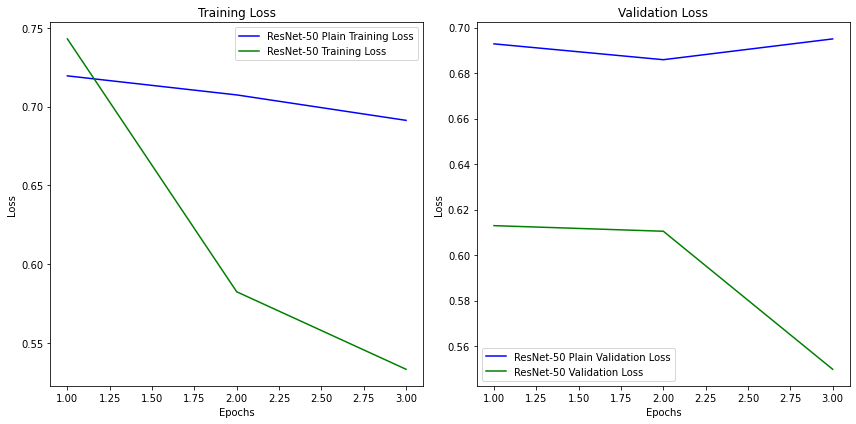

In [42]:
import matplotlib.pyplot as plt

# resnet_50_plain_history와 resnet50_history에서 loss와 val_loss 추출
resnet_50_plain_loss = resnet50_plain.history['loss']
resnet_50_plain_val_loss = resnet50_plain.history['val_loss']

resnet50_loss = resnet50.history['loss']
resnet50_val_loss = resnet50.history['val_loss']

# 훈련 과정에서 얻은 손실 값들을 시각화
epochs = range(1, len(resnet_50_plain_loss) + 1)  # epochs 수

plt.figure(figsize=(12, 6))

# resnet_50_plain , resnet50 모델의 손실 값
plt.subplot(1, 2, 1)
plt.plot(epochs, resnet_50_plain_loss, 'b', label='ResNet-50 Plain Training Loss')
plt.plot(epochs, resnet50_loss, 'g', label='ResNet-50 Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(epochs, resnet_50_plain_val_loss, 'b', label='ResNet-50 Plain Validation Loss')
plt.plot(epochs, resnet50_val_loss, 'g', label='ResNet-50 Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()